In [1]:
!pip3 install pandas


In [2]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate



## Reading the collections of database

In [3]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]

def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    #if no_id:
    #    del df['_id']

    return df


## Lendo recommendation tracks

In [4]:
recommendation_tracks = read_mongo(db="social_tracks_api", collection="recommendationtracks")
recommendation_tracks = recommendation_tracks.rename(columns = {"id" : "spotify_track_id", "_id" : "recommendation_tracks_ids" })
recommendation_tracks.drop(["__v","external_urls","album", "artists","created_at","explicit","updated_at","uri", "preview_url"],axis=1, inplace=True)

recommendation_tracks.head()

,recommendation_tracks_ids,spotify_track_id,name,prediction
0,5e38a40320eff00bbfe6eb56,5MxNLUsfh7uzROypsoO5qe,Dream On,1.192416
1,5e38a40320eff00bbfe6eb57,31AOj9sFz2gM0O3hMARRBx,Losing My Religion,1.187708
2,5e38a40420eff00bbfe6eb59,37ZJ0p5Jm13JPevGcx4SkF,Livin' On A Prayer,1.167886
3,5e38a40420eff00bbfe6eb5a,5sICkBXVmaCQk5aISGR3x1,Enter Sandman,1.140450
4,5e38a40420eff00bbfe6eb5b,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,0.972769


## Lendo Ratings

In [5]:
ratings = read_mongo(db="social_tracks_api", collection="ratings")
ratings.drop(['__v', 'created_at', 'updated_at', "_id"], axis=1, inplace=True)
ratings =  ratings.rename(columns = {"user" : "coldstart_id", 'value':'R_user'})
ratings['coldstart_id'] = ratings['coldstart_id'].astype('str')
ratings


,coldstart_id,R_user,spotify_track_id
0,5e3c828776310e1fde421f2c,5,1KGBjK7e8yq2kGiATF6RxC
1,5e3c828776310e1fde421f2c,1,5qqabIl2vWzo9ApSC317sa
2,5e3c828776310e1fde421f2c,5,2nLtzopw4rPReszdYBJU6h
3,5e3c828776310e1fde421f2c,5,5qqabIl2vWzo9ApSC317sa
4,5e39ede810214506a1c42a62,4,75JFxkI2RXiU7L9VXzMkle
...,...,...,...
319,5e39e05f10214506a1c42a61,5,2AT8iROs4FQueDv2c8q2KE
320,5e39e05f10214506a1c42a61,4,59XNy4523UcEvQfYM8fdQB
321,5e39e05f10214506a1c42a61,3,5VGlqQANWDKJFl0MBG3sg2
322,5e39e05f10214506a1c42a61,3,6nek1Nin9q48AVZcWs9e9D


In [6]:
ratings.style

,coldstart_id,R_user,spotify_track_id
0,5e3c828776310e1fde421f2c,5,1KGBjK7e8yq2kGiATF6RxC
1,5e3c828776310e1fde421f2c,1,5qqabIl2vWzo9ApSC317sa
2,5e3c828776310e1fde421f2c,5,2nLtzopw4rPReszdYBJU6h
3,5e3c828776310e1fde421f2c,5,5qqabIl2vWzo9ApSC317sa
4,5e39ede810214506a1c42a62,4,75JFxkI2RXiU7L9VXzMkle
5,5e39ede810214506a1c42a62,4,5qqabIl2vWzo9ApSC317sa
6,5e39ede810214506a1c42a62,4,5VGlqQANWDKJFl0MBG3sg2
7,5e39ede810214506a1c42a62,4,1qDrWA6lyx8cLECdZE7TV7
8,5e39ede810214506a1c42a62,5,3AJwUDP919kvQ9QcozQPxg
9,5e39ede810214506a1c42a62,5,5FVd6KXrgO9B3JPmC8OPst


In [7]:
ratings.dtypes

coldstart_id        object
R_user               int64
spotify_track_id    object
dtype: object

## Lendo id dos usuarios

In [8]:
coldstart_users = read_mongo(db="social_tracks_api", collection="users")
coldstart_users = coldstart_users[['_id']]
coldstart_users = coldstart_users.rename(columns = {'_id':'coldstart_id'})
coldstart_users['coldstart_id'] = coldstart_users['coldstart_id'].astype('str')
coldstart_users['coldstart_code'] = coldstart_users[['coldstart_id']].stack().drop_duplicates().rank(method='dense').unstack() 
coldstart_users.style


,coldstart_id,coldstart_code
0,5e3726ba1fbed90c602336a4,1.000000
1,5e39c60810214506a1c42a59,4.000000
2,5e37790d1fbed90c602336ac,2.000000
3,5e3888bf76eb8c0a84f6030c,3.000000
4,5e39e05f10214506a1c42a61,7.000000
5,5e39cb7410214506a1c42a5e,5.000000
6,5e39ede810214506a1c42a62,8.000000
7,5e3b296ded270009cf00da84,10.000000
8,5e39d31110214506a1c42a5f,6.000000
9,5e3c74b676310e1fde421f2b,12.000000


In [9]:
coldstart_users.axes

[RangeIndex(start=0, stop=20, step=1),
 Index(['coldstart_id', 'coldstart_code'], dtype='object')]

In [10]:
users =  coldstart_users.copy()
users =  users.rename(columns={'coldstart_id':'user_id', 'coldstart_code':'user_code'})
users.head()

,user_id,user_code
0,5e3726ba1fbed90c602336a4,1.0
1,5e39c60810214506a1c42a59,4.0
2,5e37790d1fbed90c602336ac,2.0
3,5e3888bf76eb8c0a84f6030c,3.0
4,5e39e05f10214506a1c42a61,7.0


## Lendo as recommendations

In [11]:
recommendations = read_mongo(db="social_tracks_api", collection="recommendations")
recommendations.drop(['_id',"__v", 'generating_recommendation', 'created_at','updated_at'], axis=1, inplace=True)
recommendations =  recommendations.rename(columns={'coldstart_user':'coldstart_id'})
recommendations['coldstart_id'] =  recommendations['coldstart_id'].astype('str')
recommendations.head()

,recommendation_tracks,recommendations_without_influence_tracks,coldstart_id,influence_factors
0,"[5e4ee9475ca8220c4dc01355, 5e4ee9475ca8220c4dc...","[5e4ee9485ca8220c4dc0135f, 5e4ee9485ca8220c4dc...",5e3b33d7ed270009cf00da85,{'final': {'5e3b33d7ed270009cf00da85': 1.09042...
1,"[5e4ef0465ca8220c4dc0136a, 5e4ef0465ca8220c4dc...","[5e4ef0475ca8220c4dc01374, 5e4ef0485ca8220c4dc...",5e3c828776310e1fde421f2c,{'final': {'5e39d31110214506a1c42a5f': 1.22941...
2,"[5e4edd995ca8220c4dc01340, 5e4edd995ca8220c4dc...","[5e4edd9a5ca8220c4dc0134a, 5e4edd9a5ca8220c4dc...",5e3726ba1fbed90c602336a4,{'final': {'5e3726ba1fbed90c602336a4': 1.18666...
3,"[5e4ef4c75ca8220c4dc01383, 5e4ef4c75ca8220c4dc...","[5e4ef4c85ca8220c4dc0138d, 5e4ef4c85ca8220c4dc...",5e39ede810214506a1c42a62,{'final': {'5e3b33d7ed270009cf00da85': 1.08978...
4,"[5e4efaa65ca8220c4dc013a5, 5e4efaa65ca8220c4dc...","[5e4efaa75ca8220c4dc013af, 5e4efaa75ca8220c4dc...",5e3888bf76eb8c0a84f6030c,{'final': {'5e3b33d7ed270009cf00da85': 1.15278...


In [12]:
recommendations.dtypes

recommendation_tracks                       object
recommendations_without_influence_tracks    object
coldstart_id                                object
influence_factors                           object
dtype: object


## Extraindo os fatores de influencia



In [13]:
influence_factors_results =  recommendations.copy()
influence_factors_results.drop(['recommendation_tracks','recommendations_without_influence_tracks' ], axis=1, inplace=True)
influence_factors_results.head()


,coldstart_id,influence_factors
0,5e3b33d7ed270009cf00da85,{'final': {'5e3b33d7ed270009cf00da85': 1.09042...
1,5e3c828776310e1fde421f2c,{'final': {'5e39d31110214506a1c42a5f': 1.22941...
2,5e3726ba1fbed90c602336a4,{'final': {'5e3726ba1fbed90c602336a4': 1.18666...
3,5e39ede810214506a1c42a62,{'final': {'5e3b33d7ed270009cf00da85': 1.08978...
4,5e3888bf76eb8c0a84f6030c,{'final': {'5e3b33d7ed270009cf00da85': 1.15278...


In [14]:
influence_factors_results.style

,coldstart_id,influence_factors
0,5e3b33d7ed270009cf00da85,"{'final': {'5e3b33d7ed270009cf00da85': 1.0904294456186723, '5e3726ba1fbed90c602336a4': 1.1845473337307584, '5e37790d1fbed90c602336ac': 1.1816925402147118, '5e3888bf76eb8c0a84f6030c': 1.3081248278071014, '5e4ea09d53da9b09dcfa3e40': 1.230618998029443, '5e39e05f10214506a1c42a61': 1.3101725714476933}, 'leadership': {'5e3b33d7ed270009cf00da85': 0.2923658768132452, '5e3726ba1fbed90c602336a4': 0.18795675345675347, '5e37790d1fbed90c602336ac': 0.3027080884762044, '5e3888bf76eb8c0a84f6030c': 0.43558725836784473, '5e4ea09d53da9b09dcfa3e40': 0.3713895590565429, '5e39e05f10214506a1c42a61': 0.4099924638294091}, 'similarities': {'5e3b33d7ed270009cf00da85': 0.08048031780426146, '5e3726ba1fbed90c602336a4': 0.09047619047619046, '5e37790d1fbed90c602336ac': 0.10100250626566414, '5e3888bf76eb8c0a84f6030c': 0.159496336996337, '5e4ea09d53da9b09dcfa3e40': 0.17118544600938965, '5e39e05f10214506a1c42a61': 0.1386581839213418}, 'expert': {'5e3b33d7ed270009cf00da85': 0, '5e3726ba1fbed90c602336a4': 0.5214805448713519, '5e37790d1fbed90c602336ac': 0.2864283239657016, '5e3888bf76eb8c0a84f6030c': 0.5214024642758981, '5e4ea09d53da9b09dcfa3e40': 0.37138523797649947, '5e39e05f10214506a1c42a61': 0.799303428910549}, 'friendly': {'5e3b33d7ed270009cf00da85': 0.07220700595700595, '5e3726ba1fbed90c602336a4': 0.07124943039416723, '5e37790d1fbed90c602336ac': 0.163667979194295, '5e3888bf76eb8c0a84f6030c': 0.3073781213912793, '5e4ea09d53da9b09dcfa3e40': 0.14380936558568136, '5e39e05f10214506a1c42a61': 0.15068606344922136}}"
1,5e3c828776310e1fde421f2c,"{'final': {'5e39d31110214506a1c42a5f': 1.2294159990258986, '5e3726ba1fbed90c602336a4': 1.3578134265140234, '5e37790d1fbed90c602336ac': 1.267802263903532, '5e3c828776310e1fde421f2c': 1.0843428998984554}, 'leadership': {'5e39d31110214506a1c42a5f': 0.44733175439697187, '5e3726ba1fbed90c602336a4': 0.3649801620816114, '5e37790d1fbed90c602336ac': 0.2841286799620133, '5e3c828776310e1fde421f2c': 0.2368927368927369}, 'similarities': {'5e39d31110214506a1c42a5f': 0.10702614379084967, '5e3726ba1fbed90c602336a4': 0.19763460939931524, '5e37790d1fbed90c602336ac': 0.248015873015873, '5e3c828776310e1fde421f2c': 0.12037037037037036}, 'expert': {'5e39d31110214506a1c42a5f': 0.2526048918592778, '5e3726ba1fbed90c602336a4': 0.7528587580980319, '5e37790d1fbed90c602336ac': 0.49453635004269003, '5e3c828776310e1fde421f2c': 0}, 'friendly': {'5e39d31110214506a1c42a5f': 0.28665123456790126, '5e3726ba1fbed90c602336a4': 0.2982142857142857, '5e37790d1fbed90c602336ac': 0.11926807760141094, '5e3c828776310e1fde421f2c': 0.01728395061728395}}"
2,5e3726ba1fbed90c602336a4,"{'final': {'5e3726ba1fbed90c602336a4': 1.1866641608210236, '5e39cb7410214506a1c42a5e': 1.1025954117313899, '5e37790d1fbed90c602336ac': 1.2672251094528324, '5e3aef57b3895f08cb77ad4a': 1.2137871680890875, '5e3c74b676310e1fde421f2b': 1.04725868120071, '5e39d31110214506a1c42a5f': 1.2238264160422958}, 'leadership': {'5e3726ba1fbed90c602336a4': 0.47497150997151005, '5e39cb7410214506a1c42a5e': 0.26237281237281235, '5e37790d1fbed90c602336ac': 0.377993302993303, '5e3aef57b3895f08cb77ad4a': 0.3096743996743997, '5e3c74b676310e1fde421f2b': 0.08055555555555556, '5e39d31110214506a1c42a5f': 0.4944324194324194}, 'similarities': {'5e3726ba1fbed90c602336a4': 0.12746965452847805, '5e39cb7410214506a1c42a5e': 0.05, '5e37790d1fbed90c602336ac': 0.1300595238095238, '5e3aef57b3895f08cb77ad4a': 0.06736111111111112, '5e3c74b676310e1fde421f2b': 0.02, '5e39d31110214506a1c42a5f': 0.0392156862745098}, 'expert': {'5e3726ba1fbed90c602336a4': 0, '5e39cb7410214506a1c42a5e': 0.21929641830964242, '5e37790d1fbed90c602336ac': 0.7530409466795621, '5e3aef57b3895f08cb77ad4a': 0.7004753194849164, '5e3c74b676310e1fde421f2b': 0.12876254180602006, '5e39d31110214506a1c42a5f': 0.6150914403865255}, 'friendly': {'5e3726ba1fbed90c602336a4': 0.27130036630036625, '5e39cb7410214506a1c42a5e': 0.014074074074074072, '5e37790d1fbed90c602336ac': 0.05322751322751322, '5e3aef57b3895f08cb77ad4a': 0

### Função de extração dos fatores de influencia

In [15]:
def influence_factors_dataframe(dict1):
    rows = []
    for factor, user_obj in dict1.items():
        for user_id, value in user_obj.items():
            #toma os valores que pertence a cada factor
            data_row =  { 'factor': factor, 'user_id': user_id, 'value': value }
            rows.append(data_row)
    return rows

In [16]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [17]:
list_factors = []
for index, df_row in influence_factors_results.iterrows():
    coldstart_id = df_row['coldstart_id']
    factors =  df_row['influence_factors']
    extract_factors =  influence_factors_dataframe(factors)
    
    for factor_row in extract_factors:
        factor_row['coldstart_id'] = coldstart_id
        
    list_factors.append(extract_factors)
    
flat_list_factors = flatten(list_factors)

In [18]:
list_factors

[[{'factor': 'final',
   'user_id': '5e3b33d7ed270009cf00da85',
   'value': 1.0904294456186723,
   'coldstart_id': '5e3b33d7ed270009cf00da85'},
  {'factor': 'final',
   'user_id': '5e3726ba1fbed90c602336a4',
   'value': 1.1845473337307584,
   'coldstart_id': '5e3b33d7ed270009cf00da85'},
  {'factor': 'final',
   'user_id': '5e37790d1fbed90c602336ac',
   'value': 1.1816925402147118,
   'coldstart_id': '5e3b33d7ed270009cf00da85'},
  {'factor': 'final',
   'user_id': '5e3888bf76eb8c0a84f6030c',
   'value': 1.3081248278071014,
   'coldstart_id': '5e3b33d7ed270009cf00da85'},
  {'factor': 'final',
   'user_id': '5e4ea09d53da9b09dcfa3e40',
   'value': 1.230618998029443,
   'coldstart_id': '5e3b33d7ed270009cf00da85'},
  {'factor': 'final',
   'user_id': '5e39e05f10214506a1c42a61',
   'value': 1.3101725714476933,
   'coldstart_id': '5e3b33d7ed270009cf00da85'},
  {'factor': 'leadership',
   'user_id': '5e3b33d7ed270009cf00da85',
   'value': 0.2923658768132452,
   'coldstart_id': '5e3b33d7ed270009

In [19]:
flat_list_factors

[{'factor': 'final',
  'user_id': '5e3b33d7ed270009cf00da85',
  'value': 1.0904294456186723,
  'coldstart_id': '5e3b33d7ed270009cf00da85'},
 {'factor': 'final',
  'user_id': '5e3726ba1fbed90c602336a4',
  'value': 1.1845473337307584,
  'coldstart_id': '5e3b33d7ed270009cf00da85'},
 {'factor': 'final',
  'user_id': '5e37790d1fbed90c602336ac',
  'value': 1.1816925402147118,
  'coldstart_id': '5e3b33d7ed270009cf00da85'},
 {'factor': 'final',
  'user_id': '5e3888bf76eb8c0a84f6030c',
  'value': 1.3081248278071014,
  'coldstart_id': '5e3b33d7ed270009cf00da85'},
 {'factor': 'final',
  'user_id': '5e4ea09d53da9b09dcfa3e40',
  'value': 1.230618998029443,
  'coldstart_id': '5e3b33d7ed270009cf00da85'},
 {'factor': 'final',
  'user_id': '5e39e05f10214506a1c42a61',
  'value': 1.3101725714476933,
  'coldstart_id': '5e3b33d7ed270009cf00da85'},
 {'factor': 'leadership',
  'user_id': '5e3b33d7ed270009cf00da85',
  'value': 0.2923658768132452,
  'coldstart_id': '5e3b33d7ed270009cf00da85'},
 {'factor': 'lea

### convertendo a lista dos fatores em dataframe

In [20]:
df_flat_factors =  pd.DataFrame(flat_list_factors)


In [21]:
df_flat_factors = df_flat_factors.rename(columns={'factor':'name_factor', 'value':'value_factor'})




In [22]:
df_flat_factors.style

,name_factor,user_id,value_factor,coldstart_id
0,final,5e3b33d7ed270009cf00da85,1.090429,5e3b33d7ed270009cf00da85
1,final,5e3726ba1fbed90c602336a4,1.184547,5e3b33d7ed270009cf00da85
2,final,5e37790d1fbed90c602336ac,1.181693,5e3b33d7ed270009cf00da85
3,final,5e3888bf76eb8c0a84f6030c,1.308125,5e3b33d7ed270009cf00da85
4,final,5e4ea09d53da9b09dcfa3e40,1.230619,5e3b33d7ed270009cf00da85
5,final,5e39e05f10214506a1c42a61,1.310173,5e3b33d7ed270009cf00da85
6,leadership,5e3b33d7ed270009cf00da85,0.292366,5e3b33d7ed270009cf00da85
7,leadership,5e3726ba1fbed90c602336a4,0.187957,5e3b33d7ed270009cf00da85
8,leadership,5e37790d1fbed90c602336ac,0.302708,5e3b33d7ed270009cf00da85
9,leadership,5e3888bf76eb8c0a84f6030c,0.435587,5e3b33d7ed270009cf00da85


### convertendo colunas em index para ordenar os dados por coldstart_id

In [23]:
df_flat_factors = df_flat_factors.set_index(['coldstart_id','user_id','name_factor'])

In [24]:
df_flat_factors

value_factor
coldstart_id             user_id                  name_factor               
5e3b33d7ed270009cf00da85 5e3b33d7ed270009cf00da85 final             1.090429
                         5e3726ba1fbed90c602336a4 final             1.184547
                         5e37790d1fbed90c602336ac final             1.181693
                         5e3888bf76eb8c0a84f6030c final             1.308125
                         5e4ea09d53da9b09dcfa3e40 final             1.230619
...                                                                      ...
5e5e75bc765acb19719b58b7 5e39d31110214506a1c42a5f similarities      0.312500
                         5e5e75bc765acb19719b58b7 similarities      0.250000
                         5e3c828776310e1fde421f2c final             1.185445
                         5e39d31110214506a1c42a5f final             1.453443
                         5e5e75bc765acb19719b58b7 final             1.100000

[430 rows x 1 columns]

### transformando cada name_factor em columna

In [25]:
df_factors_all_users = df_flat_factors.unstack()
df_factors_all_users = df_factors_all_users[[('value_factor', 'expert'),('value_factor', 'friendly'),('value_factor', 'leadership'), ('value_factor', 'similarities'), ('value_factor', 'final')]]
df_factors_all_users.style

### Eliminado os coldstart users que somente tiveram 1 amigo para criar os fatores de influencia 

### selecionando os ids dos coldstar users a ser eliminados

In [26]:
coldstart_id_delate = ['5e3aef57b3895f08cb77ad4a', '5e3c74b676310e1fde421f2b', '5e4027aa2d00d408dd04a00a', '5e4344e5df2b1f069580d6bd', '5e4423d433dcb509187b93b7']

In [27]:
df_factors_main_users = df_factors_all_users.drop(coldstart_id_delate)

df_factors_main_users.style

### reset index main users

In [28]:
df_factors_main_users.reset_index(level=1, inplace=True)
df_factors_main_users.reset_index(level=0, inplace=True)

### select ids dos main users com code do usuario

In [29]:
main_users =  df_factors_main_users.copy()
main_users = main_users[['coldstart_id']]
main_users.columns = main_users.columns.droplevel(0)
main_users = main_users.rename_axis(None, axis=1)
main_users = main_users.rename(columns={'':'coldstart_id'})
main_users = main_users.drop_duplicates(subset=['coldstart_id'], keep='first')


In [30]:
df_main_users=pd.merge(main_users, coldstart_users, on='coldstart_id')
df_main_users

,coldstart_id,coldstart_code
0,5e3726ba1fbed90c602336a4,1.0
1,5e37790d1fbed90c602336ac,2.0
2,5e3888bf76eb8c0a84f6030c,3.0
3,5e39c60810214506a1c42a59,4.0
4,5e39cb7410214506a1c42a5e,5.0
5,5e39d31110214506a1c42a5f,6.0
6,5e39e05f10214506a1c42a61,7.0
7,5e39ede810214506a1c42a62,8.0
8,5e3b296ded270009cf00da84,10.0
9,5e3b33d7ed270009cf00da85,11.0


### reset o multiIndex do df_factors_all_users para exportar tabela 

In [31]:
df_factors_all_users.reset_index(level=1, inplace=True)
df_factors_all_users.reset_index(level=0, inplace=True)

In [32]:
df_factors_all_users_code =  pd.merge(df_factors_all_users, users, on='user_id')
df_factors_all_users_code.drop([('user_id', '')], axis=1, inplace=True)
df_factors_all_users_code = df_factors_all_users_code.rename(columns={('coldstart_id', ''):'coldstart_id',
                        ('value_factor', 'expert'):'F_exp',('value_factor', 'friendly'):'F_fri',
                        ('value_factor', 'leadership'):'F_lead', ('value_factor', 'similarities'):'F_sim',
                        ('value_factor', 'final'):'Final'})


/home/aleja/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [33]:
df_factors_all_users_code =  pd.merge(df_factors_all_users_code, coldstart_users, on='coldstart_id')
df_factors_all_users_code.style

,user_id,coldstart_id,F_exp,F_fri,F_lead,F_sim,Final,user_code,coldstart_code
0,5e3726ba1fbed90c602336a4,5e3726ba1fbed90c602336a4,0.000000,0.271300,0.474972,0.127470,1.186664,1.000000,1.000000
1,5e37790d1fbed90c602336ac,5e3726ba1fbed90c602336a4,0.753041,0.053228,0.377993,0.130060,1.267225,2.000000,1.000000
2,5e39cb7410214506a1c42a5e,5e3726ba1fbed90c602336a4,0.219296,0.014074,0.262373,0.050000,1.102595,5.000000,1.000000
3,5e39d31110214506a1c42a5f,5e3726ba1fbed90c602336a4,0.615091,0.071991,0.494432,0.039216,1.223826,6.000000,1.000000
4,5e3aef57b3895f08cb77ad4a,5e3726ba1fbed90c602336a4,0.700475,0.020467,0.309674,0.067361,1.213787,9.000000,1.000000
5,5e3c74b676310e1fde421f2b,5e3726ba1fbed90c602336a4,0.128763,0.010370,0.080556,0.020000,1.047259,12.000000,1.000000
6,5e3726ba1fbed90c602336a4,5e37790d1fbed90c602336ac,0.588198,0.142678,0.291798,0.096359,1.233137,1.000000,2.000000
7,5e37790d1fbed90c602336ac,5e37790d1fbed90c602336ac,0.000000,0.187722,0.393407,0.134336,1.156248,2.000000,2.000000
8,5e39d31110214506a1c42a5f,5e37790d1fbed90c602336ac,0.212229,0.082968,0.328291,0.052549,1.129362,6.000000,2.000000
9,5e3888bf76eb8c0a84f6030c,5e37790d1fbed90c602336ac,0.596618,0.186865,0.407225,0.084615,1.257297,3.000000,2.000000


In [34]:
#df_factors_all_users['coldstart_code'] = df_factors_all_users['coldstart_id']
#df_factors_all_users['user_code'] = df_factors_all_users['user_id']


In [35]:
#df_factors_all_users[['coldstart_code', 'user_code']] = df_factors_all_users[['coldstart_code', 'user_code']].stack().drop_duplicates().rank(method='dense', ascending= False).unstack()
#df_factors_all_users

## exportando tabela fatores para latex

In [36]:
export_df_factors = df_factors_all_users_code.copy()
export_df_factors.head()

,user_id,coldstart_id,F_exp,F_fri,F_lead,F_sim,Final,user_code,coldstart_code
0,5e3726ba1fbed90c602336a4,5e3726ba1fbed90c602336a4,0.000000,0.271300,0.474972,0.127470,1.186664,1.0,1.0
1,5e37790d1fbed90c602336ac,5e3726ba1fbed90c602336a4,0.753041,0.053228,0.377993,0.130060,1.267225,2.0,1.0
2,5e39cb7410214506a1c42a5e,5e3726ba1fbed90c602336a4,0.219296,0.014074,0.262373,0.050000,1.102595,5.0,1.0
3,5e39d31110214506a1c42a5f,5e3726ba1fbed90c602336a4,0.615091,0.071991,0.494432,0.039216,1.223826,6.0,1.0
4,5e3aef57b3895f08cb77ad4a,5e3726ba1fbed90c602336a4,0.700475,0.020467,0.309674,0.067361,1.213787,9.0,1.0


In [37]:
export_df_factors =  export_df_factors.drop(columns=['coldstart_id','user_id'])


In [38]:
export_df_factors = export_df_factors[['coldstart_code','user_code','F_exp', 'F_fri', 'F_lead', 'F_sim', 'Final']]
final_export = export_df_factors.sort_values(by=('coldstart_code'), ascending = True)
final_export.style


,coldstart_code,user_code,F_exp,F_fri,F_lead,F_sim,Final
0,1.000000,1.000000,0.000000,0.271300,0.474972,0.127470,1.186664
1,1.000000,2.000000,0.753041,0.053228,0.377993,0.130060,1.267225
2,1.000000,5.000000,0.219296,0.014074,0.262373,0.050000,1.102595
3,1.000000,6.000000,0.615091,0.071991,0.494432,0.039216,1.223826
4,1.000000,9.000000,0.700475,0.020467,0.309674,0.067361,1.213787
5,1.000000,12.000000,0.128763,0.010370,0.080556,0.020000,1.047259
6,2.000000,1.000000,0.588198,0.142678,0.291798,0.096359,1.233137
7,2.000000,2.000000,0.000000,0.187722,0.393407,0.134336,1.156248
8,2.000000,6.000000,0.212229,0.082968,0.328291,0.052549,1.129362
9,2.000000,3.000000,0.596618,0.186865,0.407225,0.084615,1.257297


In [39]:
final_export['Final'] = final_export['Final'] - 1
final_export.style

,coldstart_code,user_code,F_exp,F_fri,F_lead,F_sim,Final
0,1.000000,1.000000,0.000000,0.271300,0.474972,0.127470,0.186664
1,1.000000,2.000000,0.753041,0.053228,0.377993,0.130060,0.267225
2,1.000000,5.000000,0.219296,0.014074,0.262373,0.050000,0.102595
3,1.000000,6.000000,0.615091,0.071991,0.494432,0.039216,0.223826
4,1.000000,9.000000,0.700475,0.020467,0.309674,0.067361,0.213787
5,1.000000,12.000000,0.128763,0.010370,0.080556,0.020000,0.047259
6,2.000000,1.000000,0.588198,0.142678,0.291798,0.096359,0.233137
7,2.000000,2.000000,0.000000,0.187722,0.393407,0.134336,0.156248
8,2.000000,6.000000,0.212229,0.082968,0.328291,0.052549,0.129362
9,2.000000,3.000000,0.596618,0.186865,0.407225,0.084615,0.257297


In [40]:
print(tabulate(final_export, tablefmt="latex", headers="keys"))

\begin{tabular}{rrrrrrrr}
\hline
    &   coldstart\_code &   user\_code &     F\_exp &     F\_fri &    F\_lead &     F\_sim &      Final \\
\hline
  0 &                1 &           1 & 0         & 0.2713    & 0.474972  & 0.12747   & 0.186664   \\
  1 &                1 &           2 & 0.753041  & 0.0532275 & 0.377993  & 0.13006   & 0.267225   \\
  2 &                1 &           5 & 0.219296  & 0.0140741 & 0.262373  & 0.05      & 0.102595   \\
  3 &                1 &           6 & 0.615091  & 0.0719907 & 0.494432  & 0.0392157 & 0.223826   \\
  4 &                1 &           9 & 0.700475  & 0.0204665 & 0.309674  & 0.0673611 & 0.213787   \\
  5 &                1 &          12 & 0.128763  & 0.0103704 & 0.0805556 & 0.02      & 0.0472587  \\
  6 &                2 &           1 & 0.588198  & 0.142678  & 0.291798  & 0.0963585 & 0.233137   \\
  7 &                2 &           2 & 0         & 0.187722  & 0.393407  & 0.134336  & 0.156248   \\
  8 &                2 &           6 & 0.2122

## RECOMENDAÇÕES COM INFLUENCIA SOCIAL  CONSIDERANDO TODOS OS USUARIOS

### extraindo as musicas por cada usuario da recomendação com influência social

In [41]:
recommendations_with_influence = recommendations.copy()
recommendations_with_influence.drop(['influence_factors','recommendations_without_influence_tracks'],axis=1, inplace=True)
recommendations_with_influence.head()


,recommendation_tracks,coldstart_id
0,"[5e4ee9475ca8220c4dc01355, 5e4ee9475ca8220c4dc...",5e3b33d7ed270009cf00da85
1,"[5e4ef0465ca8220c4dc0136a, 5e4ef0465ca8220c4dc...",5e3c828776310e1fde421f2c
2,"[5e4edd995ca8220c4dc01340, 5e4edd995ca8220c4dc...",5e3726ba1fbed90c602336a4
3,"[5e4ef4c75ca8220c4dc01383, 5e4ef4c75ca8220c4dc...",5e39ede810214506a1c42a62
4,"[5e4efaa65ca8220c4dc013a5, 5e4efaa65ca8220c4dc...",5e3888bf76eb8c0a84f6030c


### (unnest) desalinhando a coluna 'recommendation_tracks'

In [42]:
recommendations_with_influence = recommendations_with_influence.explode('recommendation_tracks')

In [43]:
recommendations_with_influence =  recommendations_with_influence.rename(columns = {'recommendation_tracks':'recommendation_tracks_ids', 'coldstart_user':'coldstart_id'})

In [44]:
recommendations_with_influence

,recommendation_tracks_ids,coldstart_id
0,5e4ee9475ca8220c4dc01355,5e3b33d7ed270009cf00da85
0,5e4ee9475ca8220c4dc01356,5e3b33d7ed270009cf00da85
0,5e4ee9475ca8220c4dc01357,5e3b33d7ed270009cf00da85
0,5e4ee9475ca8220c4dc01358,5e3b33d7ed270009cf00da85
0,5e4ee9475ca8220c4dc01359,5e3b33d7ed270009cf00da85
...,...,...
19,5e5e7dbf765acb19719b58c0,5e5e75bc765acb19719b58b7
19,5e5e7dc0765acb19719b58c1,5e5e75bc765acb19719b58b7
19,5e5e7dc0765acb19719b58c2,5e5e75bc765acb19719b58b7
19,5e5e7dc0765acb19719b58c3,5e5e75bc765acb19719b58b7


### merge recomendações com code_id de todos os usuarios 

In [45]:
recommendations_with_influence_all = pd.merge(recommendations_with_influence, coldstart_users, on='coldstart_id')
recommendations_with_influence_all

,recommendation_tracks_ids,coldstart_id,coldstart_code
0,5e4ee9475ca8220c4dc01355,5e3b33d7ed270009cf00da85,11.0
1,5e4ee9475ca8220c4dc01356,5e3b33d7ed270009cf00da85,11.0
2,5e4ee9475ca8220c4dc01357,5e3b33d7ed270009cf00da85,11.0
3,5e4ee9475ca8220c4dc01358,5e3b33d7ed270009cf00da85,11.0
4,5e4ee9475ca8220c4dc01359,5e3b33d7ed270009cf00da85,11.0
...,...,...,...
195,5e5e7dbf765acb19719b58c0,5e5e75bc765acb19719b58b7,20.0
196,5e5e7dc0765acb19719b58c1,5e5e75bc765acb19719b58b7,20.0
197,5e5e7dc0765acb19719b58c2,5e5e75bc765acb19719b58b7,20.0
198,5e5e7dc0765acb19719b58c3,5e5e75bc765acb19719b58b7,20.0


In [46]:
recommendations_with_influence_all.style

,recommendation_tracks_ids,coldstart_id,coldstart_code
0,5e4ee9475ca8220c4dc01355,5e3b33d7ed270009cf00da85,11.000000
1,5e4ee9475ca8220c4dc01356,5e3b33d7ed270009cf00da85,11.000000
2,5e4ee9475ca8220c4dc01357,5e3b33d7ed270009cf00da85,11.000000
3,5e4ee9475ca8220c4dc01358,5e3b33d7ed270009cf00da85,11.000000
4,5e4ee9475ca8220c4dc01359,5e3b33d7ed270009cf00da85,11.000000
5,5e4ee9485ca8220c4dc0135a,5e3b33d7ed270009cf00da85,11.000000
6,5e4ee9485ca8220c4dc0135b,5e3b33d7ed270009cf00da85,11.000000
7,5e4ee9485ca8220c4dc0135c,5e3b33d7ed270009cf00da85,11.000000
8,5e4ee9485ca8220c4dc0135d,5e3b33d7ed270009cf00da85,11.000000
9,5e4ee9485ca8220c4dc0135e,5e3b33d7ed270009cf00da85,11.000000


In [47]:
#recommendations_with_influence_all= recommendations_with_influence_all.drop(columns=[('value_factor', 'expert'),('value_factor', 'friendly'),   ('value_factor', 'leadership'),
#        ('value_factor', 'similarities') ])

#recommendations_with_influence_all = recommendations_with_influence_all.rename(columns={('user_id', '') :'user_id', ('value_factor', 'final'): 'final_factor', 
#                                                                                        ('coldstart_code', ''):'coldstart_code',('user_code', ''):'user_code'})

#recommendations_with_influence_all

### fazendo Merge das recommendações de influencia social com as infos das musicas que tem o valor da predição do sistema

In [48]:
df_influence_predictions_all = pd.merge(recommendations_with_influence_all, recommendation_tracks, on="recommendation_tracks_ids")
df_influence_predictions_all['recommendation_tracks_ids'] = df_influence_predictions_all['recommendation_tracks_ids'].astype('str')
df_influence_predictions_all.head()

,recommendation_tracks_ids,coldstart_id,coldstart_code,spotify_track_id,name,prediction
0,5e4ee9475ca8220c4dc01355,5e3b33d7ed270009cf00da85,11.0,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738
1,5e4ee9475ca8220c4dc01356,5e3b33d7ed270009cf00da85,11.0,59XNy4523UcEvQfYM8fdQB,Somebody Told Me,2.274248
2,5e4ee9475ca8220c4dc01357,5e3b33d7ed270009cf00da85,11.0,7d8GetOsjbxYnlo6Y9e5Kw,Mr. Brightside,2.270294
3,5e4ee9475ca8220c4dc01358,5e3b33d7ed270009cf00da85,11.0,31AOj9sFz2gM0O3hMARRBx,Losing My Religion,2.263324
4,5e4ee9475ca8220c4dc01359,5e3b33d7ed270009cf00da85,11.0,5qqabIl2vWzo9ApSC317sa,Wonderwall - Remastered,2.241468


In [49]:
df_influence_predictions_all.style

,recommendation_tracks_ids,coldstart_id,coldstart_code,spotify_track_id,name,prediction
0,5e4ee9475ca8220c4dc01355,5e3b33d7ed270009cf00da85,11.000000,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738
1,5e4ee9475ca8220c4dc01356,5e3b33d7ed270009cf00da85,11.000000,59XNy4523UcEvQfYM8fdQB,Somebody Told Me,2.274248
2,5e4ee9475ca8220c4dc01357,5e3b33d7ed270009cf00da85,11.000000,7d8GetOsjbxYnlo6Y9e5Kw,Mr. Brightside,2.270294
3,5e4ee9475ca8220c4dc01358,5e3b33d7ed270009cf00da85,11.000000,31AOj9sFz2gM0O3hMARRBx,Losing My Religion,2.263324
4,5e4ee9475ca8220c4dc01359,5e3b33d7ed270009cf00da85,11.000000,5qqabIl2vWzo9ApSC317sa,Wonderwall - Remastered,2.241468
5,5e4ee9485ca8220c4dc0135a,5e3b33d7ed270009cf00da85,11.000000,0gEyKnHvgkrkBM6fbeHdwK,Linger,2.196333
6,5e4ee9485ca8220c4dc0135b,5e3b33d7ed270009cf00da85,11.000000,1mea3bSkSGXuIRvnydlB5b,Viva La Vida,2.170233
7,5e4ee9485ca8220c4dc0135c,5e3b33d7ed270009cf00da85,11.000000,4VrWlk8IQxevMvERoX08iC,Chandelier,2.161498
8,5e4ee9485ca8220c4dc0135d,5e3b33d7ed270009cf00da85,11.000000,5VGlqQANWDKJFl0MBG3sg2,Use Somebody,2.151518
9,5e4ee9485ca8220c4dc0135e,5e3b33d7ed270009cf00da85,11.000000,75JFxkI2RXiU7L9VXzMkle,The Scientist,2.118469


### fazendo merge com os ratings dos usuarios 

In [50]:
df_influence_ratings_all =  pd.merge(df_influence_predictions_all, ratings, on=["spotify_track_id", "coldstart_id"])
df_influence_ratings_all.head()

,recommendation_tracks_ids,coldstart_id,coldstart_code,spotify_track_id,name,prediction,R_user
0,5e4ee9475ca8220c4dc01355,5e3b33d7ed270009cf00da85,11.0,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5
1,5e4ee9475ca8220c4dc01356,5e3b33d7ed270009cf00da85,11.0,59XNy4523UcEvQfYM8fdQB,Somebody Told Me,2.274248,5
2,5e4ee9475ca8220c4dc01357,5e3b33d7ed270009cf00da85,11.0,7d8GetOsjbxYnlo6Y9e5Kw,Mr. Brightside,2.270294,5
3,5e4ee9475ca8220c4dc01358,5e3b33d7ed270009cf00da85,11.0,31AOj9sFz2gM0O3hMARRBx,Losing My Religion,2.263324,5
4,5e4ee9475ca8220c4dc01359,5e3b33d7ed270009cf00da85,11.0,5qqabIl2vWzo9ApSC317sa,Wonderwall - Remastered,2.241468,5


In [51]:
df_influence_ratings_all.style

,recommendation_tracks_ids,coldstart_id,coldstart_code,spotify_track_id,name,prediction,R_user
0,5e4ee9475ca8220c4dc01355,5e3b33d7ed270009cf00da85,11.000000,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5
1,5e4ee9475ca8220c4dc01356,5e3b33d7ed270009cf00da85,11.000000,59XNy4523UcEvQfYM8fdQB,Somebody Told Me,2.274248,5
2,5e4ee9475ca8220c4dc01357,5e3b33d7ed270009cf00da85,11.000000,7d8GetOsjbxYnlo6Y9e5Kw,Mr. Brightside,2.270294,5
3,5e4ee9475ca8220c4dc01358,5e3b33d7ed270009cf00da85,11.000000,31AOj9sFz2gM0O3hMARRBx,Losing My Religion,2.263324,5
4,5e4ee9475ca8220c4dc01359,5e3b33d7ed270009cf00da85,11.000000,5qqabIl2vWzo9ApSC317sa,Wonderwall - Remastered,2.241468,5
5,5e4ee9485ca8220c4dc0135a,5e3b33d7ed270009cf00da85,11.000000,0gEyKnHvgkrkBM6fbeHdwK,Linger,2.196333,5
6,5e4ee9485ca8220c4dc0135b,5e3b33d7ed270009cf00da85,11.000000,1mea3bSkSGXuIRvnydlB5b,Viva La Vida,2.170233,5
7,5e4ee9485ca8220c4dc0135c,5e3b33d7ed270009cf00da85,11.000000,4VrWlk8IQxevMvERoX08iC,Chandelier,2.161498,5
8,5e4ee9485ca8220c4dc0135d,5e3b33d7ed270009cf00da85,11.000000,5VGlqQANWDKJFl0MBG3sg2,Use Somebody,2.151518,5
9,5e4ee9485ca8220c4dc0135e,5e3b33d7ed270009cf00da85,11.000000,75JFxkI2RXiU7L9VXzMkle,The Scientist,2.118469,5


### Function to normalize predictions


In [52]:
def normalize_predictions(dataframe):
    df = dataframe.copy()
    max_predic =  df.prediction.max()
    max_predic = round(max_predic,4)
    
    rate = []
    
    for x in df.prediction:
        r = abs((x/max_predic)*4)+1
        r =  round(r)
        rate.append(r)

    df["R_system"] = pd.Series(rate)
    
    
    return df

### normalizando influence ratings

In [53]:
df_influence_normalize_all =  normalize_predictions(df_influence_ratings_all)
df_influence_normalize_all.head()

,recommendation_tracks_ids,coldstart_id,coldstart_code,spotify_track_id,name,prediction,R_user,R_system
0,5e4ee9475ca8220c4dc01355,5e3b33d7ed270009cf00da85,11.0,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5,5.0
1,5e4ee9475ca8220c4dc01356,5e3b33d7ed270009cf00da85,11.0,59XNy4523UcEvQfYM8fdQB,Somebody Told Me,2.274248,5,5.0
2,5e4ee9475ca8220c4dc01357,5e3b33d7ed270009cf00da85,11.0,7d8GetOsjbxYnlo6Y9e5Kw,Mr. Brightside,2.270294,5,5.0
3,5e4ee9475ca8220c4dc01358,5e3b33d7ed270009cf00da85,11.0,31AOj9sFz2gM0O3hMARRBx,Losing My Religion,2.263324,5,5.0
4,5e4ee9475ca8220c4dc01359,5e3b33d7ed270009cf00da85,11.0,5qqabIl2vWzo9ApSC317sa,Wonderwall - Remastered,2.241468,5,5.0


In [54]:
df_influence_normalize_all.columns.values

array(['recommendation_tracks_ids', 'coldstart_id', 'coldstart_code',
       'spotify_track_id', 'name', 'prediction', 'R_user', 'R_system'],
      dtype=object)

## exportando tabela para o latex

In [55]:
export_df_influence = df_influence_normalize_all.copy()
export_df_influence = export_df_influence.drop(columns=['recommendation_tracks_ids','coldstart_id', 'spotify_track_id'])


export_df_influence = export_df_influence.sort_values(by=('coldstart_code'), ascending = True)


In [56]:
export_df_influence.style

,coldstart_code,name,prediction,R_user,R_system
27,1.000000,Nirvana smells like teen spirit - remix,1.228955,2,3.000000
26,1.000000,Wonderwall - Remastered,1.242023,4,3.000000
25,1.000000,Everlong,1.275883,3,3.000000
24,1.000000,Mr. Brightside,1.278782,4,3.000000
23,1.000000,Numb,1.283669,3,3.000000
22,1.000000,Chop Suey!,1.284016,4,3.000000
21,1.000000,In the End,1.322675,4,3.000000
30,1.000000,I Miss You,1.206332,3,3.000000
29,1.000000,Use Somebody,1.220950,4,3.000000
28,1.000000,Scar Tissue,1.227972,4,3.000000


In [57]:
print(tabulate(export_df_influence, tablefmt="latex", headers="keys"))

\begin{tabular}{rrlrrr}
\hline
     &   coldstart\_code & name                                    &   prediction &   R\_user &   R\_system \\
\hline
  27 &                1 & Nirvana smells like teen spirit - remix &     1.22896  &        2 &          3 \\
  26 &                1 & Wonderwall - Remastered                 &     1.24202  &        4 &          3 \\
  25 &                1 & Everlong                                &     1.27588  &        3 &          3 \\
  24 &                1 & Mr. Brightside                          &     1.27878  &        4 &          3 \\
  23 &                1 & Numb                                    &     1.28367  &        3 &          3 \\
  22 &                1 & Chop Suey!                              &     1.28402  &        4 &          3 \\
  21 &                1 & In the End                              &     1.32268  &        4 &          3 \\
  30 &                1 & I Miss You                              &     1.20633  &        3 &  

## graficos da relação dos ratings dado pelo sistema e os ratings dados pelos usuarios

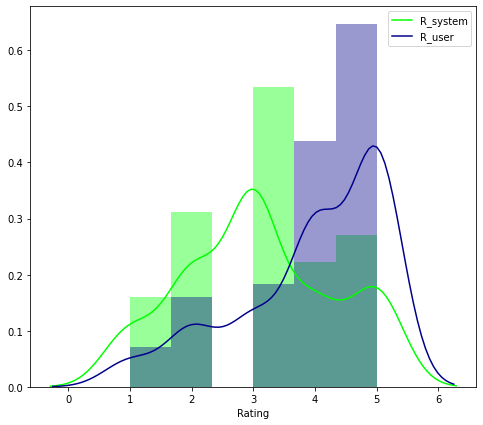

In [58]:
plt.subplots(figsize=(8, 7), sharex=True)
sns.distplot( df_influence_normalize_all["R_system"] , color="lime", 
             hist_kws={'histtype':'bar', 'stacked':'True'},
            kde_kws={'label':'R_system'})
sns.distplot( df_influence_normalize_all["R_user"] , color="darkblue", axlabel='Rating',
             hist_kws={'histtype':'bar', 'stacked':'True'},
            kde_kws={'label':'R_user'})
plt.show()

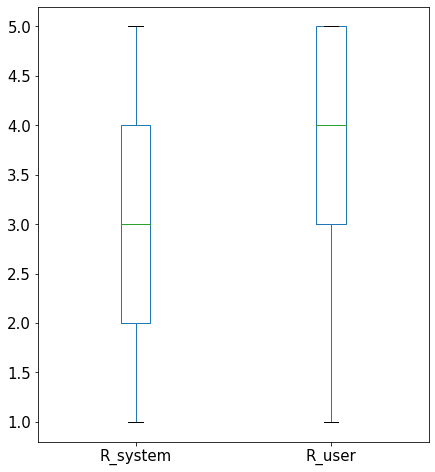

In [59]:
df_influence_normalize_all.boxplot(column=['R_system','R_user'], grid=False, fontsize=15, figsize=(7,8))

### RMSE

In [60]:
rmse_influence = sqrt(mean_squared_error(df_influence_normalize_all.R_user, df_influence_normalize_all.R_system))
rmse_influence

1.8392875586498854

## SEM INFLUENCIA SOCIAL 

### extraindo as musicas por cada usuario da recomendação sem influência social

In [61]:
recommendations_without_influence = recommendations.copy()
recommendations_without_influence.drop(['influence_factors','recommendation_tracks'], axis=1, inplace=True)
recommendations_without_influence.head()

,recommendations_without_influence_tracks,coldstart_id
0,"[5e4ee9485ca8220c4dc0135f, 5e4ee9485ca8220c4dc...",5e3b33d7ed270009cf00da85
1,"[5e4ef0475ca8220c4dc01374, 5e4ef0485ca8220c4dc...",5e3c828776310e1fde421f2c
2,"[5e4edd9a5ca8220c4dc0134a, 5e4edd9a5ca8220c4dc...",5e3726ba1fbed90c602336a4
3,"[5e4ef4c85ca8220c4dc0138d, 5e4ef4c85ca8220c4dc...",5e39ede810214506a1c42a62
4,"[5e4efaa75ca8220c4dc013af, 5e4efaa75ca8220c4dc...",5e3888bf76eb8c0a84f6030c


In [62]:
recommendations_without_influence = recommendations_without_influence.explode('recommendations_without_influence_tracks')

In [63]:
recommendations_without_influence =  recommendations_without_influence.rename(columns = {'recommendations_without_influence_tracks':'recommendation_tracks_ids', 'coldstart_user':'coldstart_id'})

In [64]:
recommendations_without_influence

,recommendation_tracks_ids,coldstart_id
0,5e4ee9485ca8220c4dc0135f,5e3b33d7ed270009cf00da85
0,5e4ee9485ca8220c4dc01360,5e3b33d7ed270009cf00da85
0,5e4ee9485ca8220c4dc01361,5e3b33d7ed270009cf00da85
0,5e4ee9485ca8220c4dc01362,5e3b33d7ed270009cf00da85
0,5e4ee9495ca8220c4dc01363,5e3b33d7ed270009cf00da85
...,...,...
19,5e5e7dc1765acb19719b58ca,5e5e75bc765acb19719b58b7
19,5e5e7dc1765acb19719b58cb,5e5e75bc765acb19719b58b7
19,5e5e7dc1765acb19719b58cc,5e5e75bc765acb19719b58b7
19,5e5e7dc1765acb19719b58cd,5e5e75bc765acb19719b58b7


### merge recomendações com  code_id de todos os users 

In [65]:
recommendations_without_influence_all = pd.merge(recommendations_without_influence, coldstart_users, on='coldstart_id')


In [66]:
recommendations_without_influence_all.style

,recommendation_tracks_ids,coldstart_id,coldstart_code
0,5e4ee9485ca8220c4dc0135f,5e3b33d7ed270009cf00da85,11.000000
1,5e4ee9485ca8220c4dc01360,5e3b33d7ed270009cf00da85,11.000000
2,5e4ee9485ca8220c4dc01361,5e3b33d7ed270009cf00da85,11.000000
3,5e4ee9485ca8220c4dc01362,5e3b33d7ed270009cf00da85,11.000000
4,5e4ee9495ca8220c4dc01363,5e3b33d7ed270009cf00da85,11.000000
5,5e4ee9495ca8220c4dc01364,5e3b33d7ed270009cf00da85,11.000000
6,5e4ee9495ca8220c4dc01365,5e3b33d7ed270009cf00da85,11.000000
7,5e4ee9495ca8220c4dc01366,5e3b33d7ed270009cf00da85,11.000000
8,5e4ee9495ca8220c4dc01367,5e3b33d7ed270009cf00da85,11.000000
9,5e4ee9495ca8220c4dc01368,5e3b33d7ed270009cf00da85,11.000000


In [67]:
#recommendations_without_influence_all= recommendations_without_influence_all.drop(columns=[('value_factor', 'expert'),('value_factor', 'friendly'), ('value_factor', 'leadership'),
#        ('value_factor', 'similarities')])

#recommendations_without_influence_all = recommendations_without_influence_all.rename(columns={('user_id', '') :'user_id', ('value_factor', 'final'): 'final_factor',
#                                                                                              ('coldstart_code', ''):'coldstart_code',('user_code', ''):'user_code'})

#recommendations_without_influence_all.head()

### fazendo Merge das recommendações de influencia social com as infos das musicas que tem o valor da predição do sistema

In [68]:
df_not_influence_predictions_all = pd.merge(recommendations_without_influence_all, recommendation_tracks, on="recommendation_tracks_ids")
df_not_influence_predictions_all['recommendation_tracks_ids'] = df_not_influence_predictions_all['recommendation_tracks_ids'].astype('str')
df_not_influence_predictions_all.head()

,recommendation_tracks_ids,coldstart_id,coldstart_code,spotify_track_id,name,prediction
0,5e4ee9485ca8220c4dc0135f,5e3b33d7ed270009cf00da85,11.0,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527
1,5e4ee9485ca8220c4dc01360,5e3b33d7ed270009cf00da85,11.0,4VrWlk8IQxevMvERoX08iC,Chandelier,1.015109
2,5e4ee9485ca8220c4dc01361,5e3b33d7ed270009cf00da85,11.0,2AT8iROs4FQueDv2c8q2KE,R U Mine?,0.978381
3,5e4ee9485ca8220c4dc01362,5e3b33d7ed270009cf00da85,11.0,7w87IxuO7BDcJ3YUqCyMTT,Pumped Up Kicks,0.967942
4,5e4ee9495ca8220c4dc01363,5e3b33d7ed270009cf00da85,11.0,5VGlqQANWDKJFl0MBG3sg2,Use Somebody,0.940242


### fazendo merge com os ratings dos usuarios 

In [69]:
df_not_influence_ratings_all =  pd.merge(df_not_influence_predictions_all, ratings, on=["spotify_track_id", "coldstart_id"])
df_not_influence_ratings_all.head()

,recommendation_tracks_ids,coldstart_id,coldstart_code,spotify_track_id,name,prediction,R_user
0,5e4ee9485ca8220c4dc0135f,5e3b33d7ed270009cf00da85,11.0,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527,5
1,5e4ee9485ca8220c4dc01360,5e3b33d7ed270009cf00da85,11.0,4VrWlk8IQxevMvERoX08iC,Chandelier,1.015109,5
2,5e4ee9485ca8220c4dc01361,5e3b33d7ed270009cf00da85,11.0,2AT8iROs4FQueDv2c8q2KE,R U Mine?,0.978381,5
3,5e4ee9485ca8220c4dc01362,5e3b33d7ed270009cf00da85,11.0,7w87IxuO7BDcJ3YUqCyMTT,Pumped Up Kicks,0.967942,5
4,5e4ee9495ca8220c4dc01363,5e3b33d7ed270009cf00da85,11.0,5VGlqQANWDKJFl0MBG3sg2,Use Somebody,0.940242,5


### normalizando influence ratings

In [70]:
df_not_influence_normalize_all =  normalize_predictions(df_not_influence_ratings_all)
df_not_influence_normalize_all.style

,recommendation_tracks_ids,coldstart_id,coldstart_code,spotify_track_id,name,prediction,R_user,R_system
0,5e4ee9485ca8220c4dc0135f,5e3b33d7ed270009cf00da85,11.000000,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527,5,3.000000
1,5e4ee9485ca8220c4dc01360,5e3b33d7ed270009cf00da85,11.000000,4VrWlk8IQxevMvERoX08iC,Chandelier,1.015109,5,3.000000
2,5e4ee9485ca8220c4dc01361,5e3b33d7ed270009cf00da85,11.000000,2AT8iROs4FQueDv2c8q2KE,R U Mine?,0.978381,5,3.000000
3,5e4ee9485ca8220c4dc01362,5e3b33d7ed270009cf00da85,11.000000,7w87IxuO7BDcJ3YUqCyMTT,Pumped Up Kicks,0.967942,5,3.000000
4,5e4ee9495ca8220c4dc01363,5e3b33d7ed270009cf00da85,11.000000,5VGlqQANWDKJFl0MBG3sg2,Use Somebody,0.940242,5,3.000000
5,5e4ee9495ca8220c4dc01364,5e3b33d7ed270009cf00da85,11.000000,62yJjFtgkhUrXktIoSjgP2,Radioactive,0.927106,5,3.000000
6,5e4ee9495ca8220c4dc01365,5e3b33d7ed270009cf00da85,11.000000,1CkvWZme3pRgbzaxZnTl5X,Rolling in the Deep,0.926441,5,3.000000
7,5e4ee9495ca8220c4dc01366,5e3b33d7ed270009cf00da85,11.000000,7d8GetOsjbxYnlo6Y9e5Kw,Mr. Brightside,0.919597,5,3.000000
8,5e4ee9495ca8220c4dc01367,5e3b33d7ed270009cf00da85,11.000000,75JFxkI2RXiU7L9VXzMkle,The Scientist,0.914183,5,3.000000
9,5e4ee9495ca8220c4dc01368,5e3b33d7ed270009cf00da85,11.000000,5qqabIl2vWzo9ApSC317sa,Wonderwall - Remastered,0.910312,5,3.000000


## graficos da relação dos ratings dado pelo sistema e os ratings dados pelos usuarios

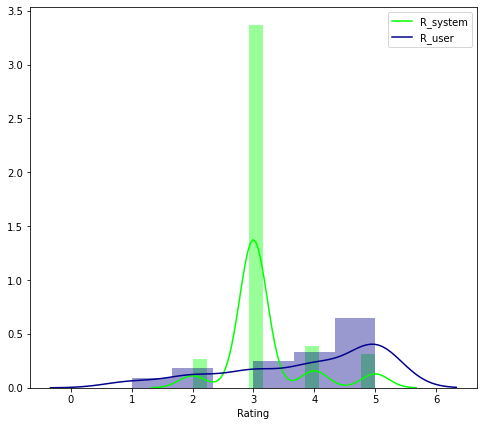

In [71]:
plt.subplots(figsize=(8, 7), sharex=True)
sns.distplot( df_not_influence_normalize_all["R_system"] , color="lime", 
             hist_kws={'histtype':'bar', 'stacked':'True'},
            kde_kws={'label':'R_system'})
sns.distplot( df_not_influence_normalize_all["R_user"] , color="darkblue", axlabel='Rating',
             hist_kws={'histtype':'bar', 'stacked':'True'},
            kde_kws={'label':'R_user'})
plt.show()

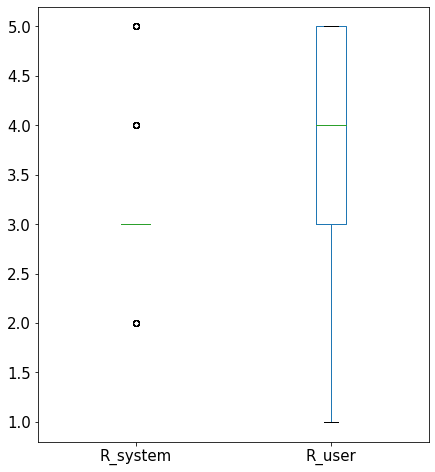

In [72]:
df_not_influence_normalize_all.boxplot(column=['R_system','R_user'], grid=False, fontsize=15, figsize=(7,8))

## RMSE

In [73]:
rmse_no_influence = sqrt(mean_squared_error(df_not_influence_normalize_all.R_user, df_not_influence_normalize_all.R_system))
rmse_no_influence

1.6708281379802852

## COM INFLUENCIA SOCIAL DOS MAIN USERS

## merge  recomendações com  code_id dos main users 


In [74]:
recommendations_with_influence_main = pd.merge(recommendations_with_influence, df_main_users, on='coldstart_id')


In [75]:
#recommendations_with_influence_main= recommendations_with_influence_main.drop(columns=[('value_factor', 'expert'),('value_factor', 'friendly'),   ('value_factor', 'leadership'),
#        ('value_factor', 'similarities') ])

#recommendations_with_influence_main = recommendations_with_influence_main.rename(columns={('user_id', '') :'user_id', ('value_factor', 'final'): 'final_factor'})

#recommendations_with_influence_main.head()

In [76]:
df_influence_predictions_main = pd.merge(recommendations_with_influence_main, recommendation_tracks, on="recommendation_tracks_ids")
df_influence_predictions_main.head()

,recommendation_tracks_ids,coldstart_id,coldstart_code,spotify_track_id,name,prediction
0,5e4ee9475ca8220c4dc01355,5e3b33d7ed270009cf00da85,11.0,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738
1,5e4ee9475ca8220c4dc01356,5e3b33d7ed270009cf00da85,11.0,59XNy4523UcEvQfYM8fdQB,Somebody Told Me,2.274248
2,5e4ee9475ca8220c4dc01357,5e3b33d7ed270009cf00da85,11.0,7d8GetOsjbxYnlo6Y9e5Kw,Mr. Brightside,2.270294
3,5e4ee9475ca8220c4dc01358,5e3b33d7ed270009cf00da85,11.0,31AOj9sFz2gM0O3hMARRBx,Losing My Religion,2.263324
4,5e4ee9475ca8220c4dc01359,5e3b33d7ed270009cf00da85,11.0,5qqabIl2vWzo9ApSC317sa,Wonderwall - Remastered,2.241468


In [77]:
df_influence_predictions_main['recommendation_tracks_ids'] = df_influence_predictions_main['recommendation_tracks_ids'].astype('str')
df_influence_predictions_main.head()


,recommendation_tracks_ids,coldstart_id,coldstart_code,spotify_track_id,name,prediction
0,5e4ee9475ca8220c4dc01355,5e3b33d7ed270009cf00da85,11.0,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738
1,5e4ee9475ca8220c4dc01356,5e3b33d7ed270009cf00da85,11.0,59XNy4523UcEvQfYM8fdQB,Somebody Told Me,2.274248
2,5e4ee9475ca8220c4dc01357,5e3b33d7ed270009cf00da85,11.0,7d8GetOsjbxYnlo6Y9e5Kw,Mr. Brightside,2.270294
3,5e4ee9475ca8220c4dc01358,5e3b33d7ed270009cf00da85,11.0,31AOj9sFz2gM0O3hMARRBx,Losing My Religion,2.263324
4,5e4ee9475ca8220c4dc01359,5e3b33d7ed270009cf00da85,11.0,5qqabIl2vWzo9ApSC317sa,Wonderwall - Remastered,2.241468


In [78]:
df_influence_ratings_main =  pd.merge(df_influence_predictions_main, ratings, on=["spotify_track_id", "coldstart_id"])
df_influence_ratings_main.style

,recommendation_tracks_ids,coldstart_id,coldstart_code,spotify_track_id,name,prediction,R_user
0,5e4ee9475ca8220c4dc01355,5e3b33d7ed270009cf00da85,11.000000,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5
1,5e4ee9475ca8220c4dc01356,5e3b33d7ed270009cf00da85,11.000000,59XNy4523UcEvQfYM8fdQB,Somebody Told Me,2.274248,5
2,5e4ee9475ca8220c4dc01357,5e3b33d7ed270009cf00da85,11.000000,7d8GetOsjbxYnlo6Y9e5Kw,Mr. Brightside,2.270294,5
3,5e4ee9475ca8220c4dc01358,5e3b33d7ed270009cf00da85,11.000000,31AOj9sFz2gM0O3hMARRBx,Losing My Religion,2.263324,5
4,5e4ee9475ca8220c4dc01359,5e3b33d7ed270009cf00da85,11.000000,5qqabIl2vWzo9ApSC317sa,Wonderwall - Remastered,2.241468,5
5,5e4ee9485ca8220c4dc0135a,5e3b33d7ed270009cf00da85,11.000000,0gEyKnHvgkrkBM6fbeHdwK,Linger,2.196333,5
6,5e4ee9485ca8220c4dc0135b,5e3b33d7ed270009cf00da85,11.000000,1mea3bSkSGXuIRvnydlB5b,Viva La Vida,2.170233,5
7,5e4ee9485ca8220c4dc0135c,5e3b33d7ed270009cf00da85,11.000000,4VrWlk8IQxevMvERoX08iC,Chandelier,2.161498,5
8,5e4ee9485ca8220c4dc0135d,5e3b33d7ed270009cf00da85,11.000000,5VGlqQANWDKJFl0MBG3sg2,Use Somebody,2.151518,5
9,5e4ee9485ca8220c4dc0135e,5e3b33d7ed270009cf00da85,11.000000,75JFxkI2RXiU7L9VXzMkle,The Scientist,2.118469,5


In [79]:
df_influence_normalize_main =  normalize_predictions(df_influence_ratings_main)
df_influence_normalize_main.head()

,recommendation_tracks_ids,coldstart_id,coldstart_code,spotify_track_id,name,prediction,R_user,R_system
0,5e4ee9475ca8220c4dc01355,5e3b33d7ed270009cf00da85,11.0,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5,5.0
1,5e4ee9475ca8220c4dc01356,5e3b33d7ed270009cf00da85,11.0,59XNy4523UcEvQfYM8fdQB,Somebody Told Me,2.274248,5,5.0
2,5e4ee9475ca8220c4dc01357,5e3b33d7ed270009cf00da85,11.0,7d8GetOsjbxYnlo6Y9e5Kw,Mr. Brightside,2.270294,5,5.0
3,5e4ee9475ca8220c4dc01358,5e3b33d7ed270009cf00da85,11.0,31AOj9sFz2gM0O3hMARRBx,Losing My Religion,2.263324,5,5.0
4,5e4ee9475ca8220c4dc01359,5e3b33d7ed270009cf00da85,11.0,5qqabIl2vWzo9ApSC317sa,Wonderwall - Remastered,2.241468,5,5.0


In [80]:
df_influence_normalize_main.style

,recommendation_tracks_ids,coldstart_id,coldstart_code,spotify_track_id,name,prediction,R_user,R_system
0,5e4ee9475ca8220c4dc01355,5e3b33d7ed270009cf00da85,11.000000,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5,5.000000
1,5e4ee9475ca8220c4dc01356,5e3b33d7ed270009cf00da85,11.000000,59XNy4523UcEvQfYM8fdQB,Somebody Told Me,2.274248,5,5.000000
2,5e4ee9475ca8220c4dc01357,5e3b33d7ed270009cf00da85,11.000000,7d8GetOsjbxYnlo6Y9e5Kw,Mr. Brightside,2.270294,5,5.000000
3,5e4ee9475ca8220c4dc01358,5e3b33d7ed270009cf00da85,11.000000,31AOj9sFz2gM0O3hMARRBx,Losing My Religion,2.263324,5,5.000000
4,5e4ee9475ca8220c4dc01359,5e3b33d7ed270009cf00da85,11.000000,5qqabIl2vWzo9ApSC317sa,Wonderwall - Remastered,2.241468,5,5.000000
5,5e4ee9485ca8220c4dc0135a,5e3b33d7ed270009cf00da85,11.000000,0gEyKnHvgkrkBM6fbeHdwK,Linger,2.196333,5,5.000000
6,5e4ee9485ca8220c4dc0135b,5e3b33d7ed270009cf00da85,11.000000,1mea3bSkSGXuIRvnydlB5b,Viva La Vida,2.170233,5,5.000000
7,5e4ee9485ca8220c4dc0135c,5e3b33d7ed270009cf00da85,11.000000,4VrWlk8IQxevMvERoX08iC,Chandelier,2.161498,5,5.000000
8,5e4ee9485ca8220c4dc0135d,5e3b33d7ed270009cf00da85,11.000000,5VGlqQANWDKJFl0MBG3sg2,Use Somebody,2.151518,5,5.000000
9,5e4ee9485ca8220c4dc0135e,5e3b33d7ed270009cf00da85,11.000000,75JFxkI2RXiU7L9VXzMkle,The Scientist,2.118469,5,5.000000


## graficos da relação dos ratings dado pelo sistema e os ratings dados pelos usuarios

In [81]:
 ##kernel density estimate

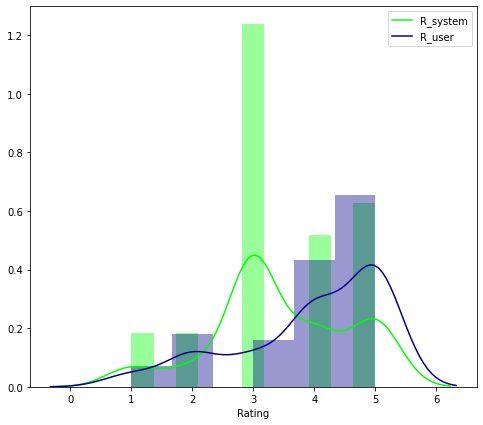

In [82]:
plt.subplots(figsize=(8, 7), sharex=True)
sns.distplot( df_influence_normalize_main["R_system"] , color="lime",
            hist_kws={'histtype':'bar', 'stacked':'True'},
            kde_kws={'label':'R_system'})
sns.distplot( df_influence_normalize_main["R_user"] , color='darkblue', axlabel='Rating',
            hist_kws={'histtype':'bar', 'stacked':'True'},
            kde_kws={'label':'R_user'})
plt.show()

In [83]:
##

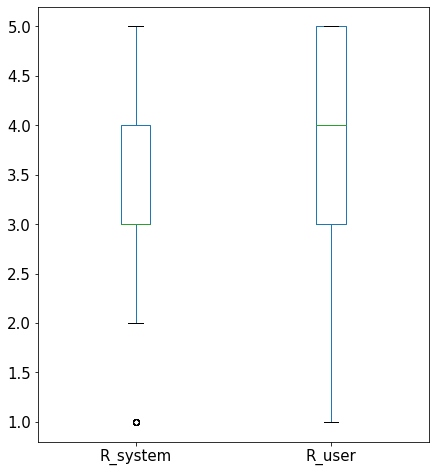

In [84]:
df_influence_normalize_main.boxplot(column=['R_system','R_user'], grid=False, fontsize=15, figsize=(7,8))


## RMSE

In [85]:
rmse_main = sqrt(mean_squared_error(df_influence_normalize_main.R_user, df_influence_normalize_main.R_system))
rmse_main

1.5651403865245448

## Average ratings of tracks considering influence

In [86]:
ratings_mean_count = pd.DataFrame(df_influence_normalize_main.groupby('name')['R_user'].mean())


In [87]:
ratings_mean_count['R_system_mean'] = pd.DataFrame(df_influence_normalize_main.groupby('name')['R_system'].mean())

In [88]:
ratings_mean_count = ratings_mean_count.rename(columns={'R_user' : 'R_user_mean'})
ratings_mean_count


,R_user_mean,R_system_mean
name,,
Alejandro,1.000000,1.000000
Bad Romance,2.000000,1.000000
Californication,4.000000,3.000000
Chandelier,4.000000,3.500000
Chop Suey!,3.500000,2.500000
Coldplay - Fix You (Remix),2.000000,5.000000
Come As You Are,5.000000,3.000000
Counting Stars,5.000000,4.000000
Crawling,4.000000,1.000000


In [95]:
print(tabulate(ratings_mean_count, tablefmt="latex", headers="keys"))

\begin{tabular}{lrr}
\hline
 name                                    &   R\_user\_mean &   R\_system\_mean \\
\hline
 Alejandro                               &       1       &         1       \\
 Bad Romance                             &       2       &         1       \\
 Californication                         &       4       &         3       \\
 Chandelier                              &       4       &         3.5     \\
 Chop Suey!                              &       3.5     &         2.5     \\
 Coldplay - Fix You (Remix)              &       2       &         5       \\
 Come As You Are                         &       5       &         3       \\
 Counting Stars                          &       5       &         4       \\
 Crawling                                &       4       &         1       \\
 Demons - Live London Sessions / 2013    &       4       &         3.66667 \\
 Diamonds                                &       2       &         2       \\
 Do I Wanna Know?        

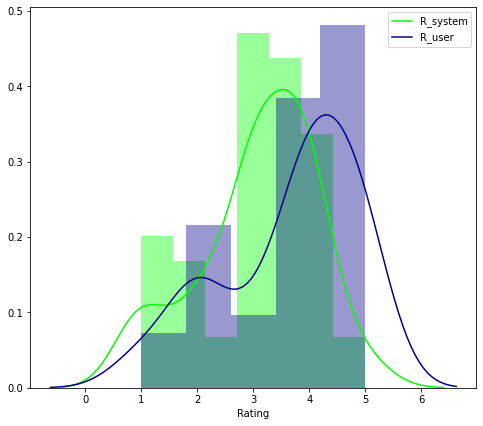

In [89]:
plt.subplots(figsize=(8, 7), sharex=True)
sns.distplot( ratings_mean_count["R_system_mean"] , color="lime",
            hist_kws={'histtype':'bar', 'stacked':'True'},
            kde_kws={'label':'R_system'})
sns.distplot( ratings_mean_count["R_user_mean"] ,color='darkblue', axlabel='Rating',
            hist_kws={'histtype':'bar', 'stacked':'True'},
            kde_kws={'label':'R_user'})
plt.show()


## Average ratings of tracks without influence

In [90]:
ratings_mean_count_not_influence =  pd.DataFrame(df_not_influence_normalize_all.groupby('name')['R_user'].mean())

In [91]:
ratings_mean_count_not_influence['R_system_mean'] = pd.DataFrame(df_not_influence_normalize_all.groupby('name')['R_system'].mean())

In [92]:
ratings_mean_count_not_influence = ratings_mean_count_not_influence.rename(columns={'R_user':'R_user_mean'})
ratings_mean_count_not_influence

,R_user_mean,R_system_mean
name,,
All The Small Things,2.000000,2.500000
Best of You,3.000000,3.000000
Bohemian Rhapsody - 2011 Mix,5.000000,3.000000
Californication,4.000000,3.000000
Chandelier,3.250000,3.500000
Chop Suey!,5.000000,3.000000
Coldplay - Fix You (Remix),1.000000,3.000000
Come As You Are,4.000000,3.000000
Counting Stars,2.500000,4.000000


In [96]:
print(tabulate(ratings_mean_count_not_influence, tablefmt="latex", headers="keys"))

\begin{tabular}{lrr}
\hline
 name                                    &   R\_user\_mean &   R\_system\_mean \\
\hline
 All The Small Things                    &       2       &         2.5     \\
 Best of You                             &       3       &         3       \\
 Bohemian Rhapsody - 2011 Mix            &       5       &         3       \\
 Californication                         &       4       &         3       \\
 Chandelier                              &       3.25    &         3.5     \\
 Chop Suey!                              &       5       &         3       \\
 Coldplay - Fix You (Remix)              &       1       &         3       \\
 Come As You Are                         &       4       &         3       \\
 Counting Stars                          &       2.5     &         4       \\
 Creep                                   &       3.5     &         3       \\
 Demons - Live London Sessions / 2013    &       3.5     &         3       \\
 Do I Wanna Know?        

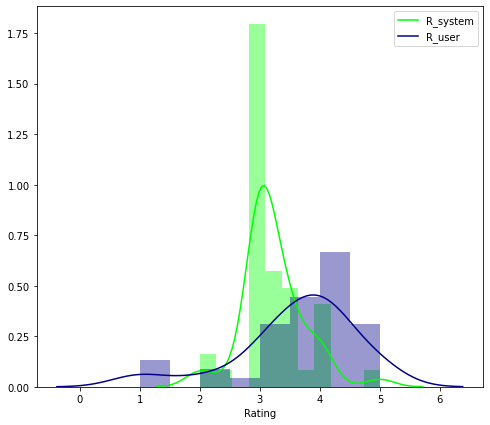

In [93]:
plt.subplots(figsize=(8, 7), sharex=True)
sns.distplot( ratings_mean_count_not_influence["R_system_mean"] , color='lime',
            hist_kws={'histtype':'bar', 'stacked':'True'},
            kde_kws={'label':'R_system'})
sns.distplot( ratings_mean_count_not_influence["R_user_mean"] , color='darkblue', axlabel='Rating',
            hist_kws={'histtype':'bar', 'stacked':'True'},
            kde_kws={'label':'R_user'})
plt.show()

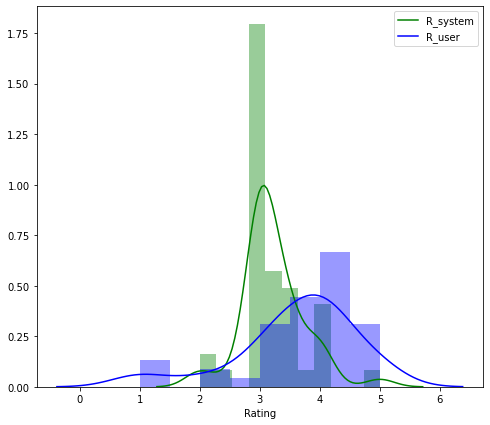

In [94]:

plt.subplots(figsize=(8, 7), sharex=True)
sns.distplot( ratings_mean_count_not_influence["R_system_mean"], color='green',
            hist_kws={'histtype':'bar', 'stacked':'True'},
            kde_kws={'label':'R_system'})
sns.distplot( ratings_mean_count_not_influence["R_user_mean"],  color='blue', axlabel='Rating',
            hist_kws={'histtype':'bar', 'stacked':'True'},
            kde_kws={'label':'R_user'})
plt.show()

## Let's now add the total number of ratings for track'

In [ ]:
#ratings_mean_count['ratings_counts'] = pd.DataFrame(df_influence_normalize_main.groupby('name')['value'].count())

In [ ]:
#ratings_mean_count.head()

### Let's plot a histogram for the number of ratings represented by the "rating_counts" column in the above dataframe.

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['ratings_counts'].hist(bins=50)

In [ ]:
### Now we'll plot a histogram for average ratings. 

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['value'].hist(bins=50)